# Notebook for the first baseline model 
Starting with PCA embeddings of RNA, using Linear Regression to predict how a clone responses to vaccination in a late time point, using data from P1 (initial time point) to predcit S1 and T1


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import pandas as pd
import numpy as np
import scirpy as ir
import anndata as ad
import scanpy as sc
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor 
import matplotlib.pyplot as plt
import moscot
from sklearn.metrics import mean_squared_error, r2_score

/opt/anaconda3/envs/vaccineSimulator/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get data & explore data

In [3]:
adata = sc.read_h5ad('/Users/juliakuhn/Desktop/uni/WS2425/cmscb/Project_phase/VaccineSimulator/02_dex_annotated_cd8.h5ad')
adata

AnnData object with n_obs × n_vars = 53907 × 18471
    obs: 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir', 'LTDEMIAQY', 'YTN

In [4]:
adata.obs

,is_cell,high_confidence,multi_chain,extra_chains,IR_VJ_1_c_call,IR_VJ_2_c_call,IR_VDJ_1_c_call,IR_VDJ_2_c_call,IR_VJ_1_consensus_count,IR_VJ_2_consensus_count,...,clr_Isotype_RTK2758,clr_Isotype_RTK4530,clr_CCR7,clr_CD62L,clr_CXCR3,clr_CD45RA,log_clone_size,TCR_mean,TCRC_mean,is_dex+
AAACCTGAGTGTTGAA-1-initial-0-0,True,True,False,[],TRAC,NaN,TRBC1,NaN,396.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.065794,1.511381,False
AAACCTGCACCAGGCT-1-initial-0-0,True,True,False,[],TRAC,NaN,TRBC1,NaN,6164.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.088723,1.310205,False
AAACCTGCATACGCTA-1-initial-0-0,True,True,False,[],TRAC,NaN,TRBC2,NaN,5506.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.484907,0.091682,0.705496,False
AAACGGGAGATGTGGC-1-initial-0-0,True,True,False,[],TRAC,NaN,NaN,NaN,4264.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.062257,0.914930,False
AAACGGGGTACGAAAT-1-initial-0-0,True,True,False,[],TRAC,NaN,TRBC2,NaN,680.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.828641,0.064372,1.095210,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCGCTCTCTGAGA-1-2-1,True,True,False,[],TRAC,NaN,TRBC1,NaN,3450.0,NaN,...,NaN,NaN,0.54596,0.0,0.000000,0.531053,0.000000,0.081136,1.335303,False
TTTGGTTGTTCGGGCT-1-2-1,True,True,False,[],TRAC,NaN,TRBC2,NaN,892.0,NaN,...,NaN,NaN,0.54596,0.0,0.197889,0.287940,1.609438,0.078837,1.086240,False
TTTGGTTTCCACGACG-1-2-1,True,True,False,[],TRAC,NaN,TRBC1,NaN,1186.0,NaN,...,NaN,NaN,0.00000,0.0,0.000000,0.360315,6.993933,0.084793,2.290340,False
TTTGTCACAGCTGCAC-1-2-1,True,True,False,[],TRAC,NaN,TRBC1,NaN,884.0,NaN,...,NaN,NaN,0.00000,0.0,0.000000,0.569542,6.993933,0.065752,1.288824,False


In [5]:
adata.var

,gene_ids,feature_types-0,genome-0,n_cells-0,feature_types-1,genome-1,highly_variable,means,dispersions,dispersions_norm
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,27,Gene Expression,GRCh38,False,0.000874,1.075864,-1.150517
AL627309.5,ENSG00000241860,Gene Expression,GRCh38,441,Gene Expression,GRCh38,False,0.023432,1.259884,-0.108835
LINC01409,ENSG00000237491,Gene Expression,GRCh38,358,Gene Expression,GRCh38,False,0.020166,1.242911,-0.204914
FAM87B,ENSG00000177757,Gene Expression,GRCh38,71,Gene Expression,GRCh38,False,0.003413,1.224581,-0.308672
LINC01128,ENSG00000228794,Gene Expression,GRCh38,1677,Gene Expression,GRCh38,False,0.097386,1.220801,-0.330072
...,...,...,...,...,...,...,...,...,...,...
AL354822.1,ENSG00000278384,Gene Expression,GRCh38,124,Gene Expression,GRCh38,True,0.006435,1.310383,0.177024
AL592183.1,ENSG00000273748,Gene Expression,GRCh38,490,Gene Expression,GRCh38,False,0.022972,1.222385,-0.321103
AC240274.1,ENSG00000271254,Gene Expression,GRCh38,378,Gene Expression,GRCh38,False,0.020251,1.274951,-0.023547
AC004556.3,ENSG00000276345,Gene Expression,GRCh38,274,Gene Expression,GRCh38,False,0.024502,1.221166,-0.328006


In [6]:
print(adata.obs.donor.cat.categories.values)
print(adata.obs.time.cat.categories.values)
adata.obs[['donor','time','experiment']].head(3)

['A02' 'A03' 'A04' 'A05' 'A06' 'A07' 'A08' 'A11' 'A15' 'A16' 'A19' 'A25'
 'A29' 'HIM']
['P1' 'S1' 'S2' 'S3' 'T1' 'T2' 'T3' 'X3' 'extra']


,donor,time,experiment
AAACCTGAGTGTTGAA-1-initial-0-0,A15,S2,first_experiment
AAACCTGCACCAGGCT-1-initial-0-0,A29,S2,first_experiment
AAACCTGCATACGCTA-1-initial-0-0,A15,S2,first_experiment


# Creat RNA Embeddings with PCA
Here, the sc.tl.pca was utlized, with manually selecting the number of principal components with the use of a variance ratio plot. Alternatively, one could use sklearn.PCA  
PCA embeddings are saved automatically in adata.obsm["X_pca"]

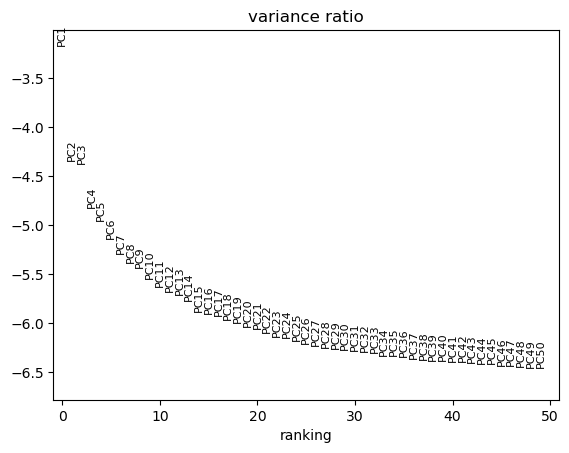

In [7]:
pca_adata = adata.copy()
sc.tl.pca(pca_adata)
sc.pl.pca_variance_ratio(pca_adata, log=True, n_pcs=50) # Elbow plot

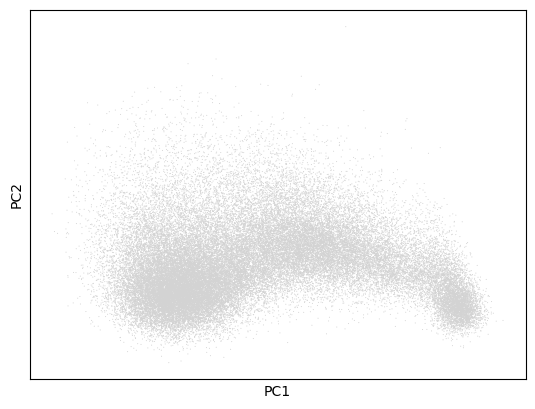

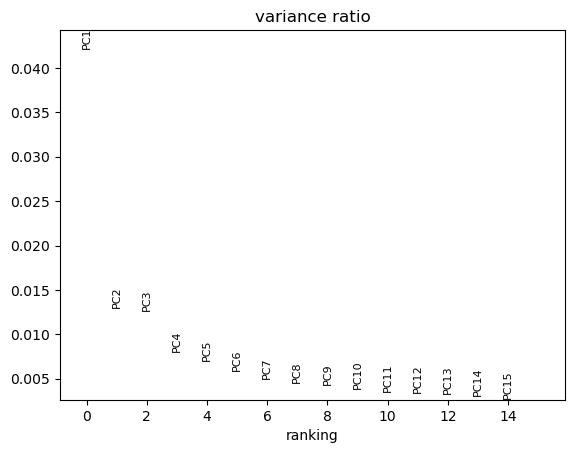

In [8]:
sc.tl.pca(adata, n_comps=15) # Perform PCA -> use 15 components since they explain 90% of the variance (plot)
sc.pl.pca(adata) # Plot only the top two principal components as they are most informative
sc.pl.pca_variance_ratio(adata, n_pcs=15) 

In [9]:
adata.obsm["X_pca"] # check if PCA was stored in adata

array([[ 7.353599  ,  2.2930684 ,  5.475095  , ..., -0.42035165,
        -0.49188307, -0.7464614 ],
       [ 8.438534  , -4.256931  ,  2.3050709 , ...,  2.3662179 ,
         0.58670783, -0.10710645],
       [-3.9699266 ,  9.784491  ,  1.751464  , ...,  2.0638733 ,
         2.7388659 , -2.1804137 ],
       ...,
       [-4.581481  , -1.3408933 ,  1.0974716 , ..., -1.164471  ,
        -1.8378661 , -0.43813595],
       [-3.7005863 , -1.7343283 , -1.1275568 , ..., -1.7393296 ,
         0.7136808 ,  0.39433032],
       [-2.018728  ,  1.920088  , -4.796494  , ...,  0.93350214,
         0.43976098,  0.09896234]], dtype=float32)

In [10]:
sc.pp.neighbors(adata, n_pcs=15, n_neighbors=15) # Compute the neighborhood graph
sc.tl.umap(adata) # Perform UMAP # TODO brauche ich das?????

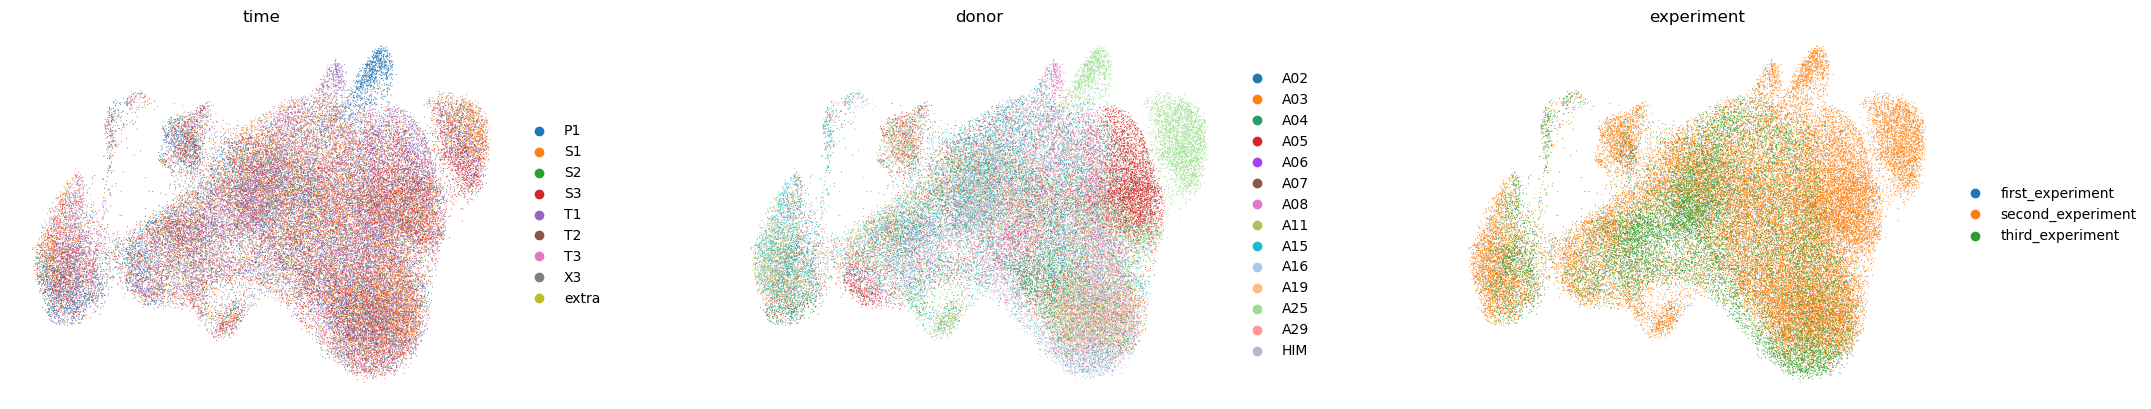

In [11]:
sc.pl.umap(adata, color=['time','donor','experiment'], frameon=False, wspace=0.3, size=2)

# Clone Aggregation and Pairing:
For each clone early and late time point data is paired.
Not all clones in P1 might exist in S1 or T1. Here, we ensure that only clones with valid response scores are included in the model training.

In [12]:
# filter out cells that we can't use
adata = adata[~adata.obs.clone_id.isna()]
adata = adata[~(adata.obs.clone_id=='nan')]
adata = adata[~(adata.obs.time.isin(['X3','extra']))]

In [13]:
# Filter for time points
P1_mask = adata.obs["time"] == "P1"
S1_mask = adata.obs["time"] == "S1"
T1_mask = adata.obs["time"] == "T1"

# Features: Embeddings from P1
X = adata[P1_mask].obsm["X_pca"]

# get target variable and clones from S1 and T1
S1_clones = adata[S1_mask].obs["clone_id"].values  # Clonotypes at S1
S1_targets = adata[S1_mask].obs["IFN Response_score"].values # target variable

T1_clones = adata[T1_mask].obs["clone_id"].values  # Clonotypes at T1
T1_targets = adata[T1_mask].obs["IFN Response_score"].values # target variable

P1_clones = adata[P1_mask].obs["clone_id"].values
P1_targets = adata[P1_mask].obs["IFN Response_score"].values    

# Cell Pairing

## Model with Cell Pairing based on timepoints

In [14]:
# Map S1 and T1 responses to corresponding P1 clones to ensure that only clones with corresponding targets are included
s1 = np.array([S1_targets[np.where(S1_clones == cid)[0][0]] if cid in S1_clones else np.nan for cid in P1_clones])
t1 = np.array([T1_targets[np.where(T1_clones == cid)[0][0]] if cid in T1_clones else np.nan for cid in P1_clones])

# Remove clones without corresponding targets
valid_indices = ~np.isnan(s1) & ~np.isnan(t1)
X, s1, t1 = X[valid_indices], s1[valid_indices], t1[valid_indices]
P1_clones = P1_clones[valid_indices]

In [15]:
# get cells per clonotype
clonotype_cell_counts = pd.DataFrame(P1_clones, columns=["Clonotype"]).value_counts().reset_index()
clonotype_cell_counts.columns = ["Clonotype", "Cell Count"]

# Display the counts per clonotype
clonotype_cell_counts

,Clonotype,Cell Count
0,897.0,297
1,926.0,216
2,30.0,160
3,870.0,141
4,171.0,136
...,...,...
3605,2551.0,0
3606,2552.0,0
3607,2553.0,0
3608,2555.0,0


In [16]:
adata.obs["clone_id"].value_counts()

clone_id
897.0      2388
30.0       1124
926.0      1090
171.0       995
855.0       747
           ... 
6607.0        1
6608.0        1
6610.0        1
6611.0        1
20300.0       1
Name: count, Length: 12701, dtype: int64

## Split into Train-Val-Test

 The splitting is done based on the unique clonotypes (unique_clonotypes_aggregated) to ensure that clones seen in the training set are not present in the test set. Here, a 80-20 split is used.

 Possible options to avoid biases:
 - split to maintain the distribution of responses in both train and test sets
 - additionally divide based on donor or experiment


### Split by Timepoint

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# X_aggregated (features), P1_clones (clonotype labels), 
# y_s1_aggregated (true target values for S1), y_p1_aggregated (true target values for P1),
# y_s1_pred (predicted values for each cell), and y_p1_pred (predictions for each cell).
# Recreate aggregated arrays aligned with unique clonotypes
X_aggregated = []  # features
y_s1_aggregated = [] # target values for s1
y_t1_aggregated = []

unique_clonotypes_aggregated = np.unique(P1_clones) # Unique clonotypes in the aggregated data


# Step 1: Split the clonotypes into train, test, and eval sets
# First, split clonotypes into train and temp (for test and eval splitting)
train_clonotypes, temp_clonotypes = train_test_split(unique_clonotypes_aggregated, test_size=0.3, random_state=42)

# Then split temp_clonotypes into test and eval (50% each)
test_clonotypes, eval_clonotypes = train_test_split(temp_clonotypes, test_size=0.5, random_state=42)

# Create masks for train, test, and eval sets based on clonotypes
train_mask = np.isin(unique_clonotypes_aggregated, train_clonotypes)
test_mask = np.isin(unique_clonotypes_aggregated, test_clonotypes)
eval_mask = np.isin(unique_clonotypes_aggregated, eval_clonotypes)

# Step 2: Aggregate features and P1 data for training (train using clonotype-level data)
for clone in unique_clonotypes_aggregated:
    mask = P1_clones == clone  # Select rows matching the current clone
    X_aggregated.append(X[mask].mean(axis=0))  # Mean of features
    y_s1_aggregated.append(s1[mask].mean())      # Mean of s1 for the clone
    y_t1_aggregated.append(t1[mask].mean())      # Mean of t1 for the clone


# Convert lists to arrays
X_aggregated = np.array(X_aggregated)
y_s1_aggregated = np.array(y_s1_aggregated)
y_t1_aggregated = np.array(y_t1_aggregated)

# Split aggregated data into train and test sets
X_train, X_test = X_aggregated[train_mask], X_aggregated[test_mask]
y_s1_train, y_s1_test = y_s1_aggregated[train_mask], y_s1_aggregated[test_mask]
y_t1_train, y_t1_test = y_t1_aggregated[train_mask], y_t1_aggregated[test_mask]

## Train Models
For the first baseline model, a Linear Regression is used, since our goal is to predict a numerical and continuous output value  (=IFN score) based on the input features. One can furthermore tune the parameters to improve this model.   
Either use Linear Regression or GBR! 

### Linear Regression

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train a model for S1 using Linear Regression
model_s1 = LinearRegression()
model_s1.fit(X_train, y_s1_train)
y_s1_pred = model_s1.predict(X_test)

# Train a model for T1 using Linear Regression
model_t1 = LinearRegression()
model_t1.fit(X_train, y_t1_train)
y_t1_pred = model_t1.predict(X_test)

### Gradient Boosting Regressor

In [28]:
from sklearn.ensemble import GradientBoostingRegressor
# Initialize and train the Gradient Boosting Regressor
gbr_s1 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_s1.fit(X_train, y_s1_train)
y_s1_pred = gbr_s1.predict(X_test)


gbr_t1 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_t1.fit(X_train, y_t1_train)
y_t1_pred = gbr_t1.predict(X_test)

# Evaluate Predictions
Calculated mse, recall at k, mean on the activated clonotypes to evaluate the correctness of the predictions

In [29]:
import numpy as np

def recall_at_k(y_true, y_pred, k):
    # Get the indices of the top-k predicted scores
    top_k_pred_indices = np.argsort(y_pred)[-k:]  # Indices of top-k predicted scores
    # Get the indices of the top-k true scores
    top_k_true_indices = np.argsort(y_true)[-k:]  # Indices of top-k true scores

    # Compute intersection of predicted and true top-k indices
    intersection = np.intersect1d(top_k_pred_indices, top_k_true_indices)

    # Compute Recall@k
    recall_k = len(intersection) / k
    return recall_k


In [30]:
def aggregate_predictions_by_clonotype(y_pred):
    """
    Aggregate responses by clonotype.

    Args:
        y_pred (array-like): Responses (predicted) for each cell.

    Returns:
        dict: A dictionary mapping each clonotype to its predicted responses.
    """
    test_clonotype_labels = unique_clonotypes_aggregated[test_mask]  # Get the clonotype labels for the test set


    # Create an empty dictionary to store predictions for each clonotype
    predictions_by_clonotype = {}

    # Iterate over each unique clonotype in the test set
    for clonotype in np.unique(test_clonotype_labels):
        # Get indices of the test samples corresponding to this clonotype
        clonotype_mask = test_clonotype_labels == clonotype

        # Get the predicted values for this clonotype
        clonotype_predictions = y_pred[clonotype_mask]

        # Store these predictions in the dictionary
        predictions_by_clonotype[clonotype] = clonotype_predictions

    return predictions_by_clonotype

In [31]:
def recall_at_k_clonotype(y_true, y_pred, k):
    """
    Compute recall at K based on clonotype-level responsiveness.

    Args:
        y_true (array-like): True responses for each cell.
        y_pred (array-like): Predicted responses for each cell.
        k (int): Number of top clonotypes to consider.

    Returns:
        float: Recall at K based on clonotypes.

        
    """
    
    # Aggregate responses by clonotype
    true_responses_by_clonotype = aggregate_predictions_by_clonotype(y_true)
    pred_responses_by_clonotype = aggregate_predictions_by_clonotype(y_pred)

    # Sort clonotypes by their average true and predicted responses -> # TODO why? 
    top_k_true_clonotypes = sorted(
        true_responses_by_clonotype, key=true_responses_by_clonotype.get, reverse=True
    )[:k]
    top_k_pred_clonotypes = sorted(
        pred_responses_by_clonotype, key=pred_responses_by_clonotype.get, reverse=True
    )[:k]

    # Compute the intersection of top-k true and predicted clonotypes
    intersection = set(top_k_true_clonotypes) & set(top_k_pred_clonotypes)

    # Compute Recall@K
    recall_k = len(intersection) / k
    return recall_k

In [32]:
def mse_clonotype(y_pred, y_true):
    """
    Aggregate responses by clonotype and calculate MSE per clonotype.

    Args:
        y_pred (array-like): Predicted responses for each cell.
        y_true (array-like): True responses for each cell.

    Returns:
        dict: A dictionary mapping each clonotype to its predicted responses and MSE.
        float: The mean MSE across all clonotypes.
    """

    # Get the clonotype labels for the test set (assumed to be pre-defined)
    test_clonotype_labels = unique_clonotypes_aggregated[test_mask]  # Make sure test_mask is defined
     
    # Create an empty dictionary to store predictions and MSE for each clonotype
    predictions_by_clonotype = {}
    mse_by_clonotype = {}

    # Iterate over each unique clonotype in the test set
    for clonotype in np.unique(test_clonotype_labels):
        # Get indices of the test samples corresponding to this clonotype
        clonotype_mask = test_clonotype_labels == clonotype

        # Get the predicted values and true values for this clonotype
        clonotype_predictions = y_pred[clonotype_mask]
        clonotype_true_values = y_true[clonotype_mask]

        # Calculate the MSE for this clonotype
        mse = mean_squared_error(clonotype_true_values, clonotype_predictions)

        # Store predictions and MSE in the dictionary
        predictions_by_clonotype[clonotype] = clonotype_predictions
        mse_by_clonotype[clonotype] = mse

    # Calculate the mean MSE across all clonotypes
    mean_mse = np.mean(list(mse_by_clonotype.values()))

    return mse_by_clonotype, mean_mse


In [33]:
k = 5

# Evaluate S1 predictions
mse_s1 = mean_squared_error(y_s1_test, y_s1_pred)
mse_s1_clonotype, mse_s1_mean = mse_clonotype(y_s1_test, y_s1_pred)

recall_ks1 = recall_at_k_clonotype(
    y_s1_test,
    y_s1_pred,
    k
)
mean_clonotype_activation_s1_predicted = y_s1_pred.mean()  # Predicted mean clonotype activation for the test set
mean_clonotype_activation_s1 = y_s1_test.mean()# True mean clonotype activation for the test set

print(f"Recall@{k} for S1: {recall_ks1:.2f}")
print(f"MSE- Mean for S1: {mse_s1_mean}")
print(f"Mean Clonotype Activation (S1): {mean_clonotype_activation_s1:.4f}")
print(f"Mean Clonotype Activation (S1) Predicted: {mean_clonotype_activation_s1_predicted:.4f}")



# Evaluate T1 predictions
mse_t1 = mean_squared_error(y_t1_test, y_t1_pred)
mse_t1_clonotype, mse_t1_mean = mse_clonotype(y_t1_test, y_t1_pred)
recall_kt1 = recall_at_k_clonotype(
    y_t1_test,
    y_t1_pred,
    k
)
mean_clonotype_activation_t1 = y_t1_test.mean()
mean_clonotype_activation_t1_predicted = y_t1_pred.mean()

print(f"Recall@{k} for T1: {recall_kt1:.2f}")
print(f"MSE- Mean for T1: {mse_t1_mean}")
print(f"Mean Clonotype Activation (T1): {mean_clonotype_activation_t1:.4f}")
print(f"Mean Clonotype Activation (T1) Predicted: {mean_clonotype_activation_t1_predicted:.4f}")


Recall@5 for S1: 0.20
MSE- Mean for S1: 0.06432385392380861
Mean Clonotype Activation (S1): -0.0323
Mean Clonotype Activation (S1) Predicted: -0.0293
Recall@5 for T1: 0.20
MSE- Mean for T1: 0.14767001446252098
Mean Clonotype Activation (T1): 0.0856
Mean Clonotype Activation (T1) Predicted: 0.0623


In [40]:
import numpy as np
from sklearn.metrics import mean_squared_error

k = 5  # Recall@k setting

# --- Standard Evaluation ---
# Evaluate S1 predictions
mse_s1 = mean_squared_error(y_s1_test, y_s1_pred)
mse_s1_clonotype, mse_s1_mean = mse_clonotype(y_s1_test, y_s1_pred)
recall_ks1 = recall_at_k_clonotype(y_s1_test, y_s1_pred, k)

mean_clonotype_activation_s1_predicted = y_s1_pred.mean()
mean_clonotype_activation_s1 = y_s1_test.mean()

print(f"Recall@{k} for S1: {recall_ks1:.2f}")
print(f"MSE- Mean for S1: {mse_s1}")
print(f"MSE- Clonotype mean for S1: {mse_s1_mean}")
print(f"Mean Clonotype Activation (S1): {mean_clonotype_activation_s1:.4f}")
print(f"Mean Clonotype Activation (S1) Predicted: {mean_clonotype_activation_s1_predicted:.4f}")

# --- Quartile MSE Analysis for S1 ---
# Sort clones by true response level
sorted_indices_s1 = np.argsort(y_s1_test)

# Get quartile indices
q1_s1 = sorted_indices_s1[: len(sorted_indices_s1) // 4]  # Bottom 25% (low responders)
q4_s1 = sorted_indices_s1[-len(sorted_indices_s1) // 4:]  # Top 25% (high responders)

# Compute MSE for the two quartiles
mse_s1_low = mean_squared_error(y_s1_test[q1_s1], y_s1_pred[q1_s1])
mse_s1_high = mean_squared_error(y_s1_test[q4_s1], y_s1_pred[q4_s1])

print(f"MSE for bottom 25% (low-responding clones) in S1: {mse_s1_low:.4f}")
print(f"MSE for top 25% (high-responding clones) in S1: {mse_s1_high:.4f}")

# --- Standard Evaluation for T1 ---
mse_t1 = mean_squared_error(y_t1_test, y_t1_pred)
mse_t1_clonotype, mse_t1_mean = mse_clonotype(y_t1_test, y_t1_pred)
recall_kt1 = recall_at_k_clonotype(y_t1_test, y_t1_pred, k)

mean_clonotype_activation_t1 = y_t1_test.mean()
mean_clonotype_activation_t1_predicted = y_t1_pred.mean()

print(f"Recall@{k} for T1: {recall_kt1:.2f}")
print(f"MSE- Mean for T1: {mse_t1}")
print(f"MSE- Clonotype mean for T1: {mse_t1_mean}")
print(f"Mean Clonotype Activation (T1): {mean_clonotype_activation_t1:.4f}")
print(f"Mean Clonotype Activation (T1) Predicted: {mean_clonotype_activation_t1_predicted:.4f}")

# --- Quartile MSE Analysis for T1 ---
sorted_indices_t1 = np.argsort(y_t1_test)

q1_t1 = sorted_indices_t1[: len(sorted_indices_t1) // 4]  # Bottom 25%
q4_t1 = sorted_indices_t1[-len(sorted_indices_t1) // 4:]  # Top 25%

mse_t1_low = mean_squared_error(y_t1_test[q1_t1], y_t1_pred[q1_t1])
mse_t1_high = mean_squared_error(y_t1_test[q4_t1], y_t1_pred[q4_t1])

print(f"MSE for bottom 25% (low-responding clones) in T1: {mse_t1_low:.4f}")
print(f"MSE for top 25% (high-responding clones) in T1: {mse_t1_high:.4f}")

Recall@5 for S1: 0.20
MSE- Mean for S1: 0.06432385392380861
MSE- Clonotype mean for S1: 0.06432385392380861
Mean Clonotype Activation (S1): -0.0323
Mean Clonotype Activation (S1) Predicted: -0.0293
MSE for bottom 25% (low-responding clones) in S1: 0.0527
MSE for top 25% (high-responding clones) in S1: 0.1606
Recall@5 for T1: 0.20
MSE- Mean for T1: 0.14767001446252098
MSE- Clonotype mean for T1: 0.14767001446252098
Mean Clonotype Activation (T1): 0.0856
Mean Clonotype Activation (T1) Predicted: 0.0623
MSE for bottom 25% (low-responding clones) in T1: 0.1390
MSE for top 25% (high-responding clones) in T1: 0.3231


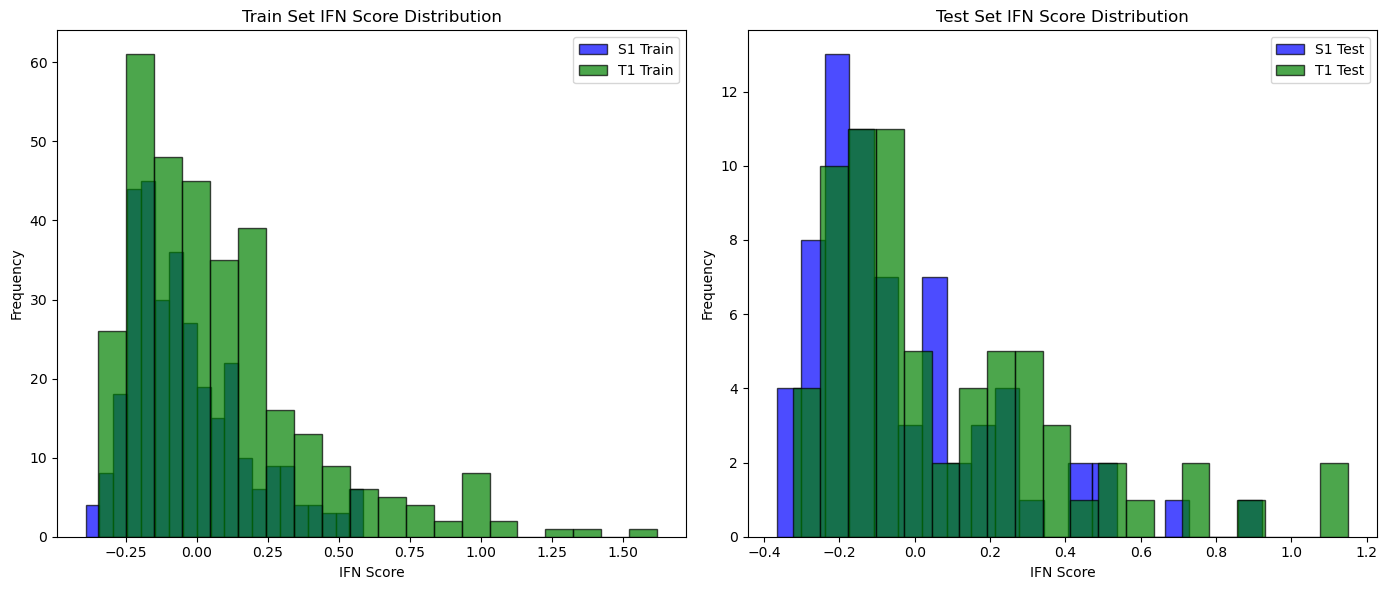

In [34]:
# plot the IFN score for train and  test subset
import matplotlib.pyplot as plt

# Plot IFN score distributions for train and test sets
plt.figure(figsize=(14, 6))

# Train distribution
plt.subplot(1, 2, 1)
plt.hist(y_s1_train, bins=20, alpha=0.7, label="S1 Train", color="blue", edgecolor="black")
plt.hist(y_t1_train, bins=20, alpha=0.7, label="T1 Train", color="green", edgecolor="black")
plt.title("Train Set IFN Score Distribution")
plt.xlabel("IFN Score")
plt.ylabel("Frequency")
plt.legend()

# Test distribution
plt.subplot(1, 2, 2)
plt.hist(y_s1_test, bins=20, alpha=0.7, label="S1 Test", color="blue", edgecolor="black")
plt.hist(y_t1_test, bins=20, alpha=0.7, label="T1 Test", color="green", edgecolor="black")
plt.title("Test Set IFN Score Distribution")
plt.xlabel("IFN Score")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

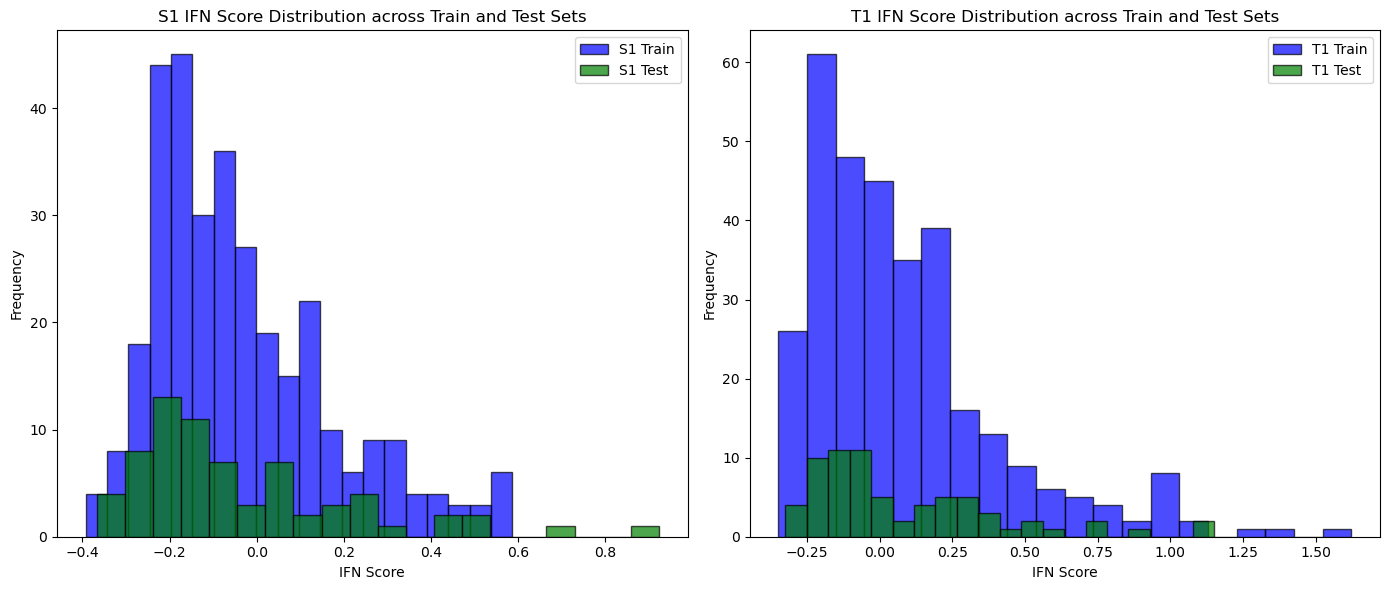

In [35]:
# plot the IFN score for train and  test subset
import matplotlib.pyplot as plt

# Plot IFN score distributions for train and test sets
plt.figure(figsize=(14, 6))

# Train distribution
plt.subplot(1, 2, 1)
plt.hist(y_s1_train, bins=20, alpha=0.7, label="S1 Train", color="blue", edgecolor="black")
plt.hist(y_s1_test, bins=20, alpha=0.7, label="S1 Test", color="green", edgecolor="black")
plt.title("S1 IFN Score Distribution across Train and Test Sets")
plt.xlabel("IFN Score")
plt.ylabel("Frequency")
plt.legend()

# Test distribution
plt.subplot(1, 2, 2)
plt.hist(y_t1_train, bins=20, alpha=0.7, label="T1 Train", color="blue", edgecolor="black")
plt.hist(y_t1_test, bins=20, alpha=0.7, label="T1 Test", color="green", edgecolor="black")
plt.title("T1 IFN Score Distribution across Train and Test Sets")
plt.xlabel("IFN Score")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

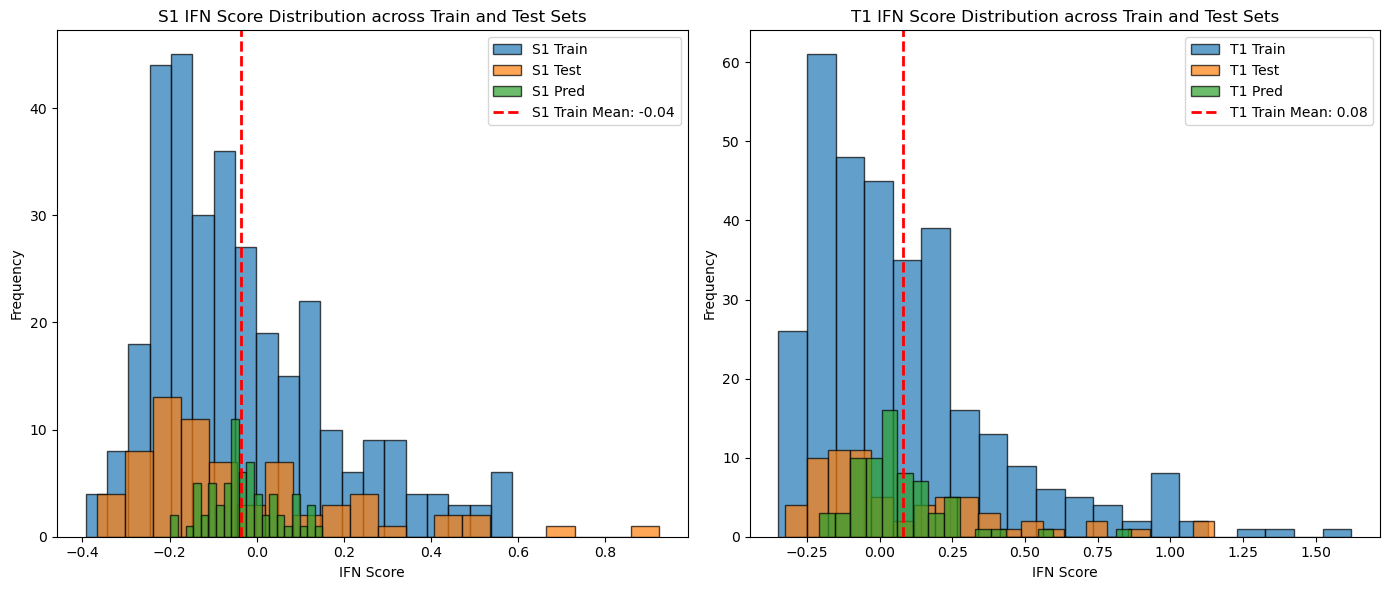

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the means of the distributions
mean_s1_train = np.mean(y_s1_train)

mean_t1_train = np.mean(y_t1_train)

# Plot IFN score distributions for train and test sets
plt.figure(figsize=(14, 6))

# S1 distribution
plt.subplot(1, 2, 1)
plt.hist(y_s1_train, bins=20, alpha=0.7, label="S1 Train", edgecolor="black")
plt.hist(y_s1_test, bins=20, alpha=0.7, label="S1 Test", edgecolor="black")
plt.hist(y_s1_pred, bins=20, alpha=0.7, label="S1 Pred", edgecolor="black")
plt.axvline(mean_s1_train, color='red', linestyle='dashed', linewidth=2, label=f"S1 Train Mean: {mean_s1_train:.2f}")
plt.title("S1 IFN Score Distribution across Train and Test Sets")
plt.xlabel("IFN Score")
plt.ylabel("Frequency")
plt.legend()

# T1 distribution
plt.subplot(1, 2, 2)
plt.hist(y_t1_train, bins=20, alpha=0.7, label="T1 Train", edgecolor="black")
plt.hist(y_t1_test, bins=20, alpha=0.7, label="T1 Test", edgecolor="black")
plt.hist(y_t1_pred, bins=20, alpha=0.7, label="T1 Pred", edgecolor="black")
plt.axvline(mean_t1_train, color='red', linestyle='dashed', linewidth=2, label=f"T1 Train Mean: {mean_t1_train:.2f}")
plt.title("T1 IFN Score Distribution across Train and Test Sets")
plt.xlabel("IFN Score")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()


In [37]:
plt.figure(figsize=(12, 6))

# Plotting true vs predicted S1 for each clonotype (with a color map for MSE)
scatter = plt.scatter(y_s1_test, y_s1_pred, c=mse_values, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='MSE per Clonotype')

plt.xlabel('True S1 Values')
plt.ylabel('Predicted S1 Values')
plt.title('True vs Predicted S1 with MSE Color Map')
plt.tight_layout()
plt.show()

NameError: name 'mse_values' is not defined

<Figure size 1200x600 with 0 Axes>

In [ ]:
# You want to compare the distribution of P1, S1_test, and S1_pred per clonotype

# Plotting the results
clonotypes = [f'Clone {i+1}' for i in range(len(np.unique(test_clonotypes)))]

# Set up the figure
plt.figure(figsize=(12, 6))

# Define the bar width
bar_width = 0.25
index = np.arange(len(clonotypes))

# Plot each of the distributions
plt.bar(index - bar_width, y_p1_test, bar_width, label='P1', color='lightblue')
plt.bar(index, y_s1_test, bar_width, label='S1 Test', color='lightgreen')
plt.bar(index + bar_width, y_s1_pred, bar_width, label='S1 Predicted', color='salmon')

# Add labels, title, and legend
plt.xlabel('Clonotype')
plt.ylabel('Mean Value')
plt.title('Distribution of P1, S1 Test, and S1 Predicted per Clonotype')
plt.xticks(index, clonotypes, rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Explore Results

Focussing on the most active clones 

In [28]:
# Creating a DataFrame with clone IDs, true scores, and predictions
results_df = pd.DataFrame({
    "Clone_ID": unique_clonotypes_aggregated[test_mask],  # Clonotypes in the test set
    "True_S1_Score": y_s1_test,  # True target values for S1
    "Predicted_S1_Score": model_s1.predict(X_s1_test),  # Predicted values for S1
    "True_T1_Score": y_t1_test,  # True target values for T1
    "Predicted_T1_Score": model_s1.predict(X_t1_test),  # Predicted values for T1
})


In [29]:
# Aggregate scores by clone
clone_summary = results_df.groupby("Clone_ID").agg(
    Mean_True_S1_Score=("True_S1_Score", "mean"),
    Mean_Predicted_S1_Score=("Predicted_S1_Score", "mean"),
    Mean_True_T1_Score=("True_T1_Score", "mean"),
    Mean_Predicted_T1_Score=("Predicted_T1_Score", "mean")
).reset_index()

# Sort clones by highest predicted scores for S1 or T1
top_clones = clone_summary.sort_values(by="Mean_Predicted_S1_Score", ascending=False).head(30)
print(top_clones)


   Clone_ID  Mean_True_S1_Score  Mean_Predicted_S1_Score  Mean_True_T1_Score  \
29  18174.0           -0.162282                 0.130834           -0.047664   
9   12157.0            0.036488                 0.107138            1.117963   
47    359.0           -0.121326                 0.081074            0.560592   
26  17933.0           -0.061935                 0.078250            0.188739   
55    627.0            0.225359                 0.072620           -0.220331   
24  17882.0            0.188243                 0.065188           -0.220140   
30  18281.0            0.110276                 0.059674            0.245320   
2    1061.0            0.264781                 0.050070            1.150848   
25  17903.0            0.328644                 0.049412           -0.309307   
36   2296.0           -0.182169                 0.036870           -0.132135   
11   1293.0            0.452820                 0.034037            0.364765   
63    900.0           -0.262952         

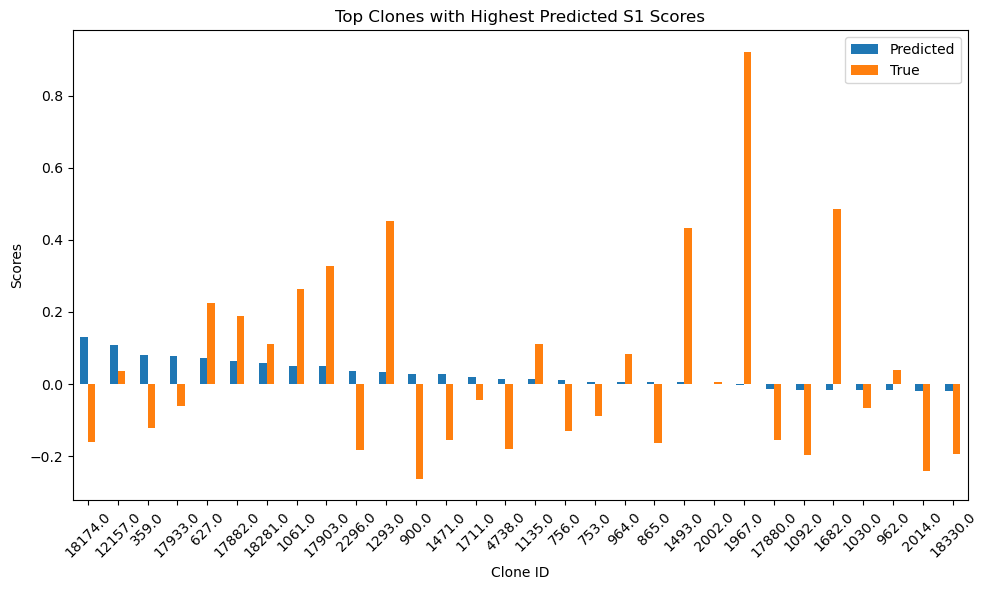

In [ ]:
# Bar plot for top clones
top_clones.plot(
    x="Clone_ID",
    y=["Mean_Predicted_S1_Score", "Mean_True_S1_Score"],
    kind="bar",
    figsize=(10, 6),
    title="Top Clones with Highest Predicted S1 Scores"
)
plt.ylabel("Scores")
plt.xlabel("Clone ID")
plt.xticks(rotation=45)
plt.legend(["Predicted", "True"])
plt.tight_layout()
plt.show()


In [31]:
"""TODO 
import pandas as pd

# Korrelation zwischen den verschiedenen Zeitpunkten berechnen
correlation_matrix = results_df[['True_S1_Score', 'True_T1_Score', 'True_P1_Score']].corr()
print(correlation_matrix)"""


"TODO \nimport pandas as pd\n\n# Korrelation zwischen den verschiedenen Zeitpunkten berechnen\ncorrelation_matrix = results_df[['True_S1_Score', 'True_T1_Score', 'True_P1_Score']].corr()\nprint(correlation_matrix)"

In [ ]:
# investigating clone with top scores
top_clone_ids = top_clones["Clone_ID"].values
top_clone_metadata = adata.obs.loc[adata.obs["clone_id"].isin(top_clone_ids)]
print(top_clone_metadata)


                               is_cell high_confidence multi_chain  \
CCTTACGCAACTGCTA-1-initial-0-0    True            True       False   
GGGTTGCTCTTCAACT-1-initial-0-0    True            True       False   
GTTTCTAAGGATATAC-1-initial-0-0    True            True       False   
TATCAGGCATTGGTAC-1-initial-0-0    True            True       False   
TCGGGACAGGATGGTC-1-initial-0-0    True            True       False   
...                                ...             ...         ...   
GTGTTAGTCTAGAGTC-1-2-1            True            True       False   
GTTACAGTCGGAGCAA-1-2-1            True            True       False   
TAAGTGCCATATACGC-1-2-1            True            True       False   
TAGGCATTCAAGGCTT-1-2-1            True            True       False   
TAGTTGGGTCATACTG-1-2-1            True            True       False   

                               extra_chains IR_VJ_1_c_call IR_VJ_2_c_call  \
CCTTACGCAACTGCTA-1-initial-0-0           []           TRAC            NaN   
GGGTT

In [33]:
# Compute MSE for top clones
top_clones_mse = mean_squared_error(
    top_clones["Mean_True_S1_Score"], top_clones["Mean_Predicted_S1_Score"]
)
print(f"Mean Squared Error for Top Clones (S1): {top_clones_mse:.4f}")

Mean Squared Error for Top Clones (S1): 0.0735


### Using only the top highest score per clone

In [34]:
# Create a DataFrame with clone IDs, true scores, and predictions
results_df = pd.DataFrame({
    "Clone_ID": unique_clonotypes_aggregated[test_mask],  # Clonotypes in the test set
    "True_S1_Score": y_s1_test,  # True target values for S1
    "Predicted_S1_Score": model_s1.predict(X_s1_test),  # Predicted values for S1
    "True_T1_Score": y_t1_test,  # True target values for T1
    "Predicted_T1_Score": model_s1.predict(X_t1_test)  # Predicted values for T1
})


In [35]:
# Select the highest predicted score for each clone
top_scores_per_clone = results_df.groupby("Clone_ID").agg(
    Max_True_S1_Score=("True_S1_Score", "max"),
    Max_Predicted_S1_Score=("Predicted_S1_Score", "max"),
    Max_True_T1_Score=("True_T1_Score", "max"),
    Max_Predicted_T1_Score=("Predicted_T1_Score", "max")
).reset_index()

# Sort by the highest predicted S1 scores
top_scores_per_clone = top_scores_per_clone.sort_values(by="Max_Predicted_S1_Score", ascending=False)


In [36]:
# Select the top 10 clones
top_clones = top_scores_per_clone.head(10)
print(top_clones)


   Clone_ID  Max_True_S1_Score  Max_Predicted_S1_Score  Max_True_T1_Score  \
29  18174.0          -0.162282                0.130834          -0.047664   
9   12157.0           0.036488                0.107138           1.117963   
47    359.0          -0.121326                0.081074           0.560592   
26  17933.0          -0.061935                0.078250           0.188739   
55    627.0           0.225359                0.072620          -0.220331   
24  17882.0           0.188243                0.065188          -0.220140   
30  18281.0           0.110276                0.059674           0.245320   
2    1061.0           0.264781                0.050070           1.150848   
25  17903.0           0.328644                0.049412          -0.309307   
36   2296.0          -0.182169                0.036870          -0.132135   

    Max_Predicted_T1_Score  
29                0.130834  
9                 0.107138  
47                0.081074  
26                0.078250  
55     

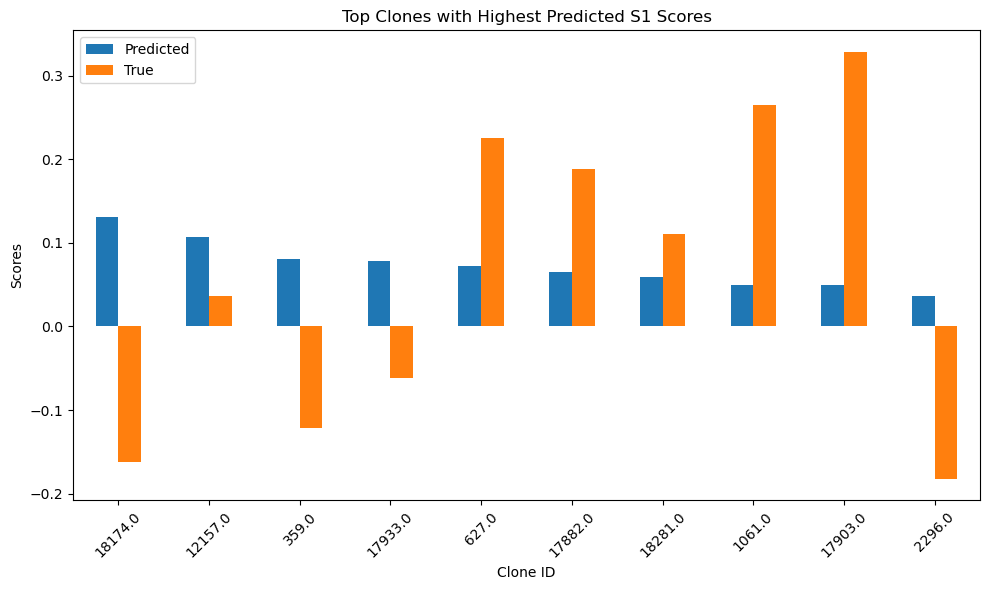

In [ ]:
import matplotlib.pyplot as plt

# Bar plot for top clones
top_clones.plot(
    x="Clone_ID",
    y=["Max_Predicted_S1_Score", "Max_True_S1_Score"],
    kind="bar",
    figsize=(10, 6),
    title="Top Clones with Highest Predicted S1 Scores"
)
plt.ylabel("Scores")
plt.xlabel("Clone ID")
plt.xticks(rotation=45)
plt.legend(["Predicted", "True"])
plt.tight_layout()
plt.show()


## Visualize Results

In [38]:
clonotypes = adata.obs[['clone_id','time']].value_counts().reset_index().pivot(columns='time', index='clone_id', values='count')
clonotypes['sum']=clonotypes.sum(axis=1)
clonotypes = clonotypes.sort_values(by='sum', ascending=False)
clonotypes = clonotypes[(~clonotypes.isna()).sum(axis=1) > 2]

In [39]:
clonotypes_ifn = clonotypes.iloc[:,0:-1].copy()
for clone in tqdm(clonotypes_ifn.index):
    for time in clonotypes_ifn.columns:
        clonotypes_ifn.loc[clone,time] = adata.obs.loc[(adata.obs.clone_id == clone) & (adata.obs.time == time),'IFN Response_score'].mean()

100%|██████████| 1763/1763 [00:02<00:00, 638.74it/s]


In [40]:
clonotypes_ifn['sum'] = clonotypes['sum']

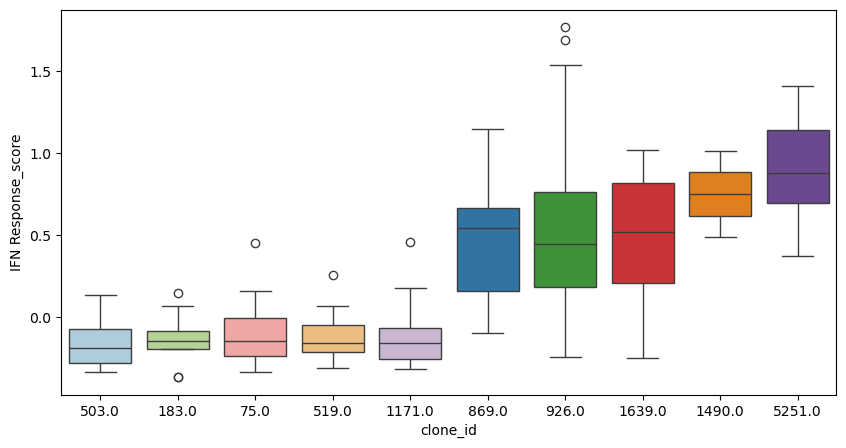

In [ ]:
clones = clonotypes_ifn[(~clonotypes_ifn.T1.isna()) & (clonotypes_ifn['sum'] > 50)].sort_values(by='T1').index
clones = clones[0:5].tolist() + clones[-6:-1].tolist()
dt = adata[adata.obs.clone_id.isin(clones) & (adata.obs.time == 'T1')].obs[['clone_id','IFN Response_score']]
dt.loc[:,['clone response']] = dt['clone_id'].map({clone: ('NR' if i < 5 else 'R') for i, clone in enumerate(clones)})

rcParams['figure.figsize'] = (10, 5)
sns.boxplot(data=dt, x="clone_id", y="IFN Response_score", hue="clone_id", palette='Paired', hue_order=np.array(clones)[[0,5,1,6,2,7,3,8,4,9]], order=clones)
rcParams['figure.figsize'] = (5, 4)

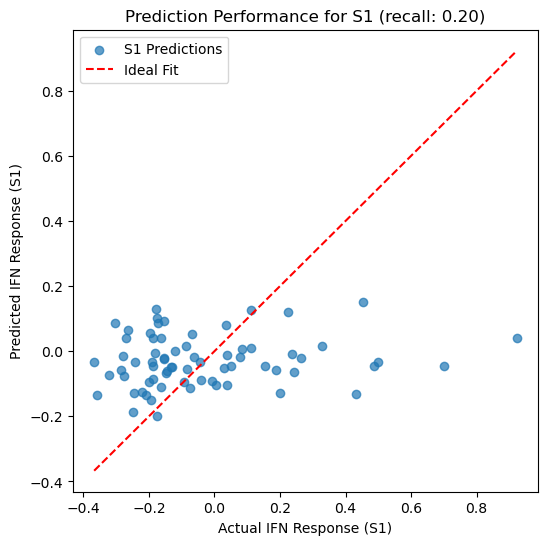

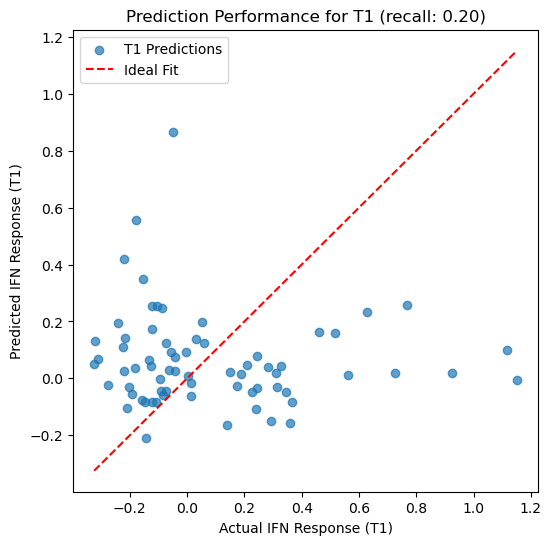

In [ ]:
import matplotlib.pyplot as plt

# Visualization for S1
plt.figure(figsize=(6, 6))
plt.scatter(y_s1_test, y_s1_pred, alpha=0.7, label="S1 Predictions")
plt.plot([y_s1_test.min(), y_s1_test.max()], [y_s1_test.min(), y_s1_test.max()], 'r--', label="Ideal Fit")
plt.xlabel("Actual IFN Response (S1)")
plt.ylabel("Predicted IFN Response (S1)")
plt.title(f"Prediction Performance for S1 (recall: {recall_ks1:.2f})")
plt.legend()
plt.show()

# Visualization for T1
plt.figure(figsize=(6, 6))
plt.scatter(y_t1_test, y_t1_pred, alpha=0.7, label="T1 Predictions")
plt.plot([y_t1_test.min(), y_t1_test.max()], [y_t1_test.min(), y_t1_test.max()], 'r--', label="Ideal Fit")
plt.xlabel("Actual IFN Response (T1)")
plt.ylabel("Predicted IFN Response (T1)")
plt.title(f"Prediction Performance for T1 (recall: {recall_kt1:.2f})")
plt.legend()
plt.show()


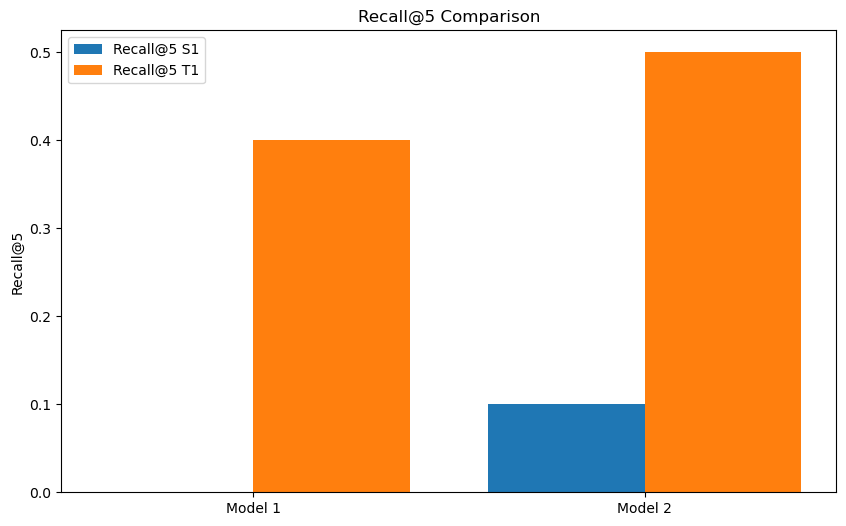

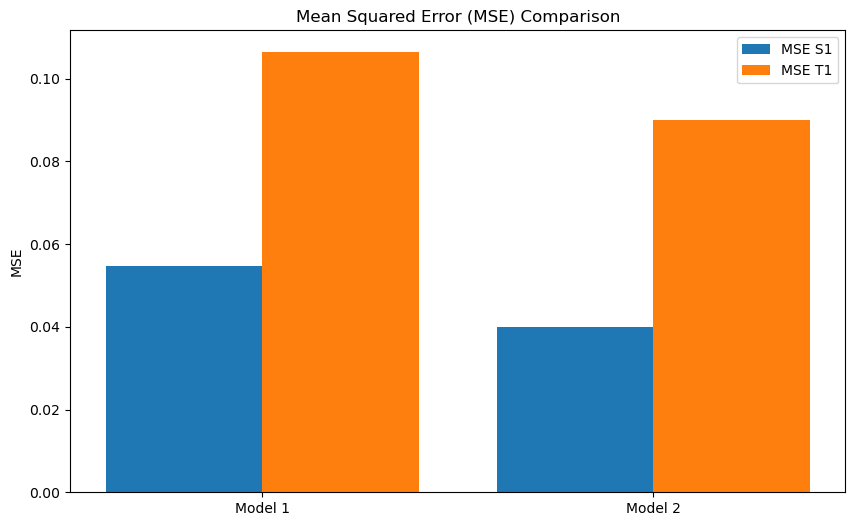

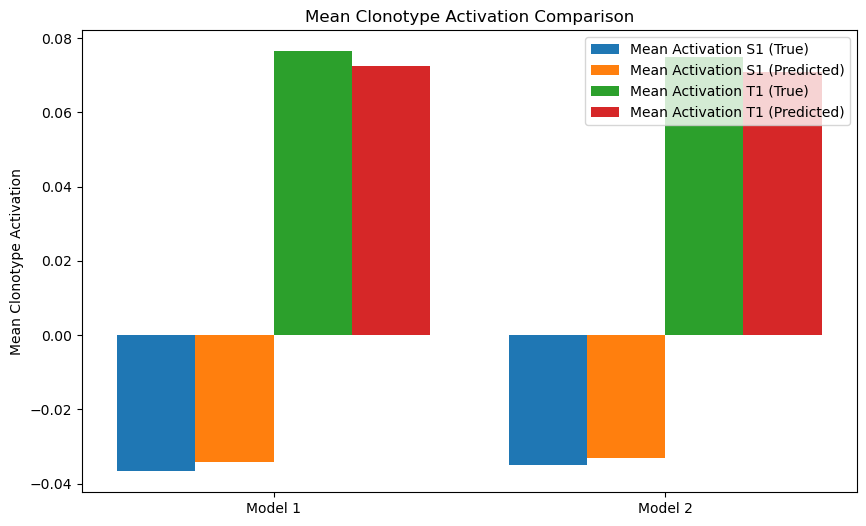

In [ ]:
# TODO jsut the concept, add values

# Example metrics for two models
models = ['Model 1', 'Model 2']  # Add more models as needed
recall_s1 = [0.00, 0.10]  # Replace with Recall@5 for S1 across models
recall_t1 = [0.40, 0.50]  # Replace with Recall@5 for T1 across models
mse_s1 = [0.0547, 0.0400]  # Replace with MSE for S1 across models
mse_t1 = [0.1064, 0.0900]  # Replace with MSE for T1 across models
mean_activation_s1 = [-0.0367, -0.0350]  # Replace with Mean Clonotype Activation (True) for S1
mean_activation_s1_pred = [-0.0342, -0.0330]  # Replace with Mean Clonotype Activation (Predicted) for S1
mean_activation_t1 = [0.0765, 0.0750]  # Replace with Mean Clonotype Activation (True) for T1
mean_activation_t1_pred = [0.0724, 0.0710]  # Replace with Mean Clonotype Activation (Predicted) for T1

x = np.arange(len(models))  # X locations for the groups

# Plot Recall@5
plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, recall_s1, width=0.4, label='Recall@5 S1')
plt.bar(x + 0.2, recall_t1, width=0.4, label='Recall@5 T1')
plt.xticks(x, models)
plt.ylabel('Recall@5')
plt.title('Recall@5 Comparison')
plt.legend()
plt.show()

# Plot MSE
plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, mse_s1, width=0.4, label='MSE S1')
plt.bar(x + 0.2, mse_t1, width=0.4, label='MSE T1')
plt.xticks(x, models)
plt.ylabel('MSE')
plt.title('Mean Squared Error (MSE) Comparison')
plt.legend()
plt.show()

# Plot Mean Clonotype Activation
plt.figure(figsize=(10, 6))
bar_width = 0.2
plt.bar(x - 0.3, mean_activation_s1, width=bar_width, label='Mean Activation S1 (True)')
plt.bar(x - 0.1, mean_activation_s1_pred, width=bar_width, label='Mean Activation S1 (Predicted)')
plt.bar(x + 0.1, mean_activation_t1, width=bar_width, label='Mean Activation T1 (True)')
plt.bar(x + 0.3, mean_activation_t1_pred, width=bar_width, label='Mean Activation T1 (Predicted)')
plt.xticks(x, models)
plt.ylabel('Mean Clonotype Activation')
plt.title('Mean Clonotype Activation Comparison')
plt.legend()
plt.show()


# Tune Parameters 

In [44]:
params = {
    "n_estimators": 100, 
    "learning_rate": 0.1, 
    "max_depth": 3, 
    "random_state": 42,
    'device': 'mps'
}

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, randint

# Define parameter distribution
param_dist = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'subsample': uniform(0.7, 0.3),
    'max_features': ['sqrt', 'log2', None]
} # TODO do these parameters make sense?

# Initialize GradientBoostingRegressor
gbr = GradientBoostingRegressor()

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    scoring='neg_mean_squared_error',
    cv=3,  # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

"""
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1
)
"""

# Fit the model
random_search.fit(X_s1_train, y_s1_train)

# Output the best parameters and the corresponding score
print("Best parameters:", random_search.best_params_)
print("Best score:", -random_search.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters: {'learning_rate': 0.010518486277398677, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 57, 'subsample': 0.910590063177311}
Best score: 0.04249621891511715


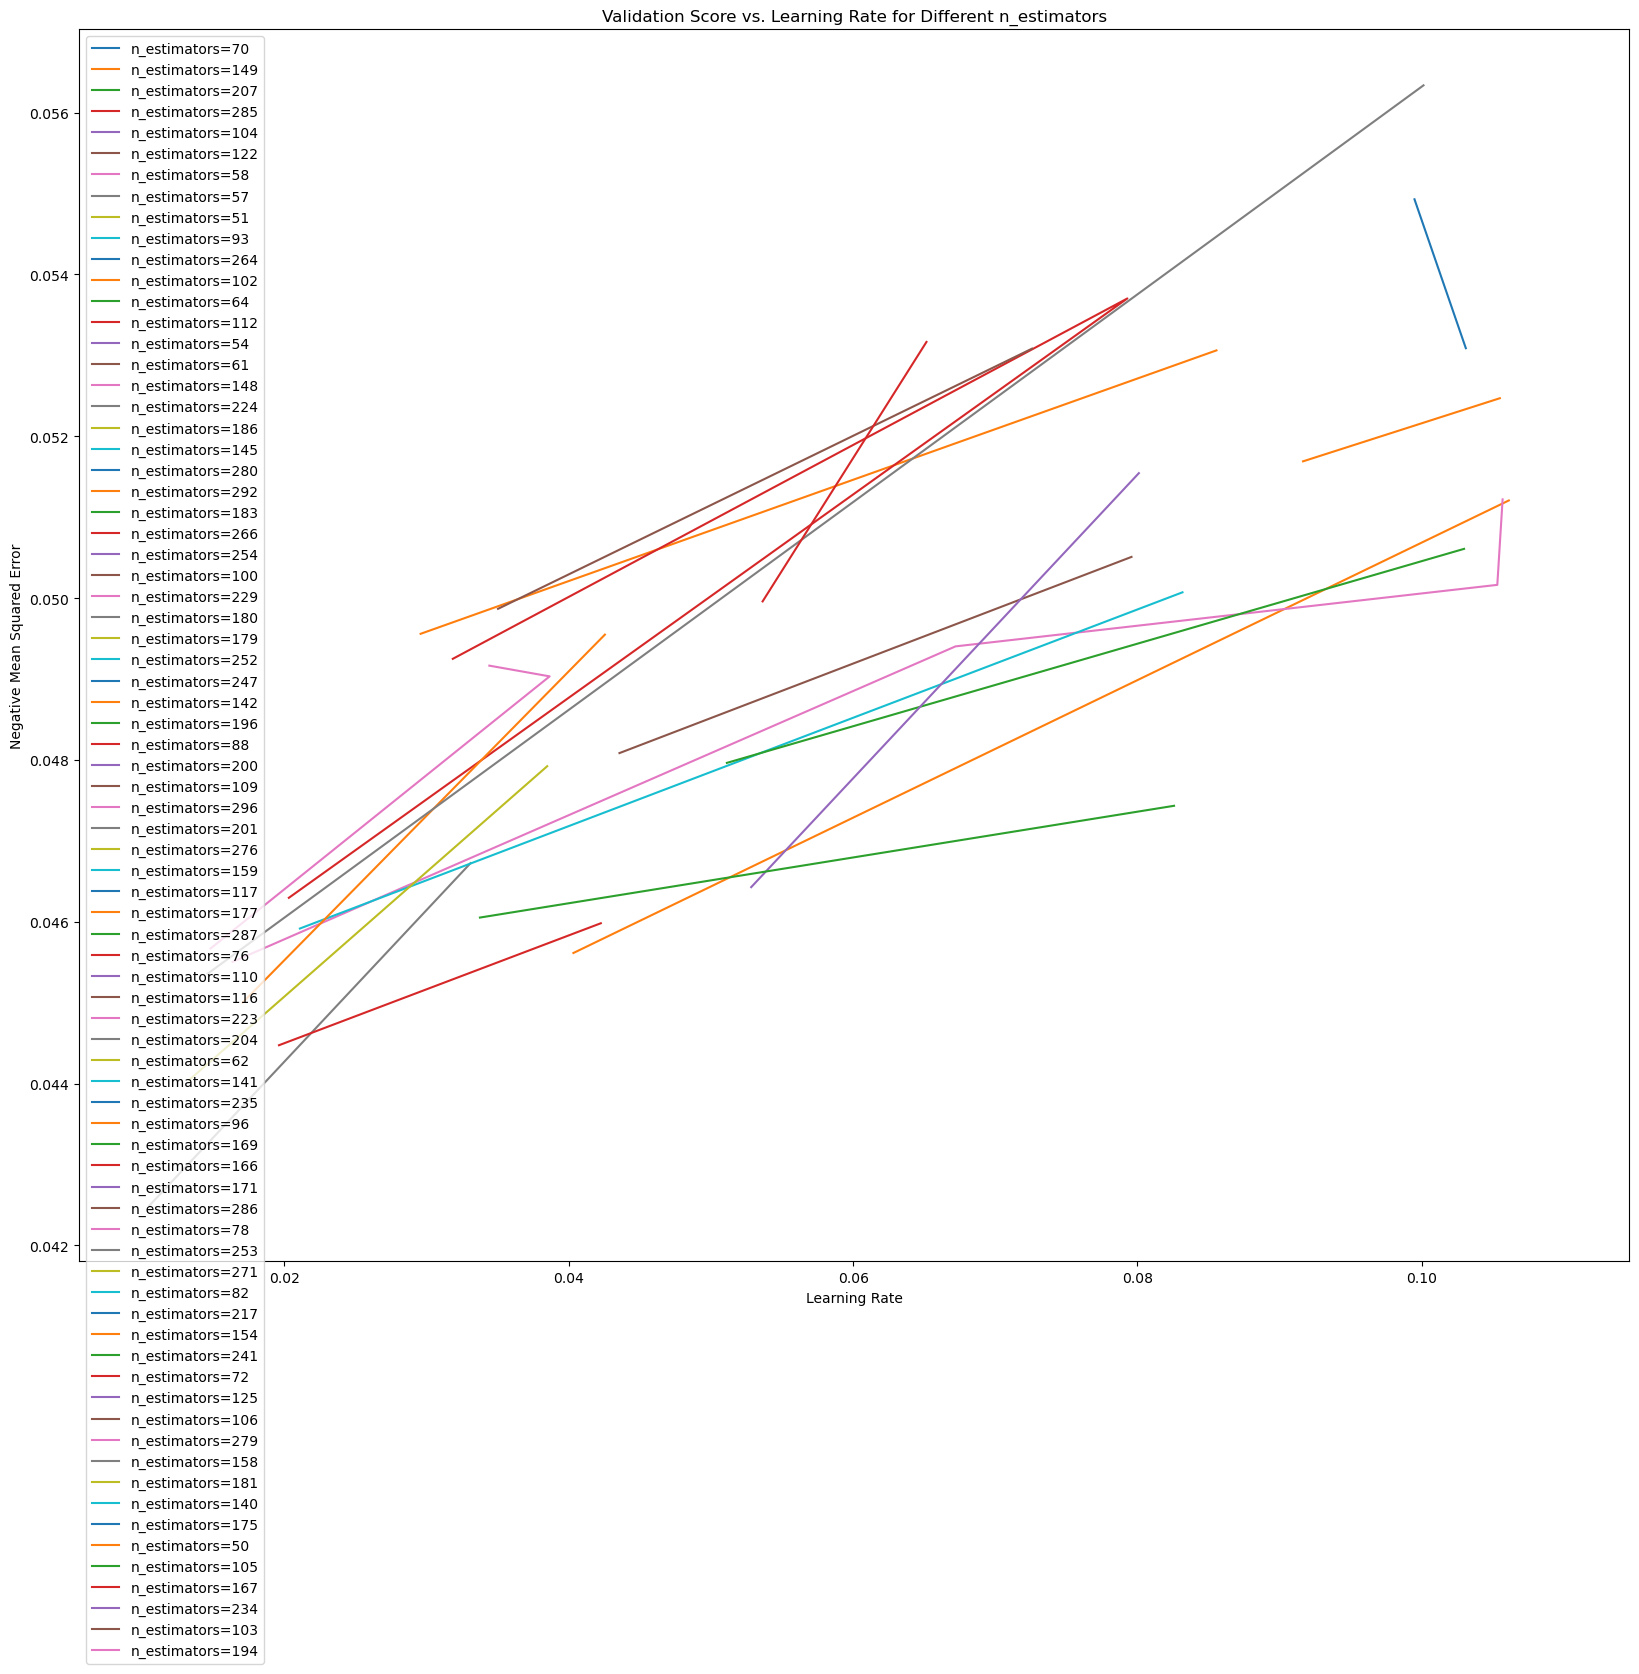

In [ ]:
#Plotting param tunign results
results = pd.DataFrame(random_search.cv_results_)

# Example: Visualizing validation score for different learning rates
plt.figure(figsize=(20, 16))
for n_estimators in results['param_n_estimators'].unique():
    subset = results[results['param_n_estimators'] == n_estimators]
    plt.plot(subset['param_learning_rate'], -subset['mean_test_score'], label=f'n_estimators={n_estimators}')

plt.xlabel('Learning Rate')
plt.ylabel('Negative Mean Squared Error')
plt.title('Validation Score vs. Learning Rate for Different n_estimators')
plt.legend()
plt.show()

TypeError: 'float' object is not iterable

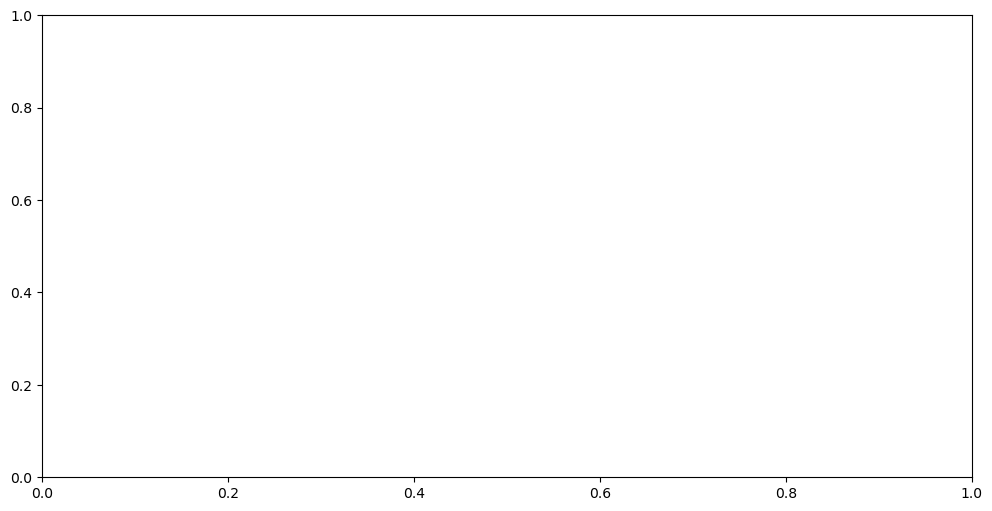

In [39]:
# Create a single figure for all metrics, distinguishing between models
fig, ax = plt.subplots(figsize=(12, 6))

# Define colors for each model
model_colors = {
    "Baseline": "blue",
    "LinReg Timepoint": "green",
    "Grad Boosting Timepoint": "orange",
    "LinReg Donor": "purple",
    "Grad Boosting Donor": "red",
    "LinReg OT": "cyan",
    "Grad Boosting OT": "magenta"
}

# Prepare data for boxplot (transpose so each metric is a separate set)
data_values_transposed = list(map(list, zip(*data_values)))

# Positions for boxplots
positions = np.arange(len(metrics))

# Plot boxplots for each model
for i, (model, values) in enumerate(data.items()):
    values_transposed = list(map(list, zip(*values)))  # Transpose data for each metric
    for j, metric_values in enumerate(values_transposed):
        if not np.isnan(metric_values).all():  # Avoid NaN-only boxes
            ax.boxplot(metric_values, positions=[positions[j] + i * 0.1], widths=0.1,
                       patch_artist=True, boxprops=dict(facecolor=model_colors[model], alpha=0.6),
                       medianprops=dict(color="black"))

# Add labels and title
ax.set_xticks(positions)
ax.set_xticklabels(metrics, rotation=45, fontsize=10)
ax.set_ylabel("Values", fontsize=12)
ax.set_title("Comparison of Metrics Across Models", fontsize=14, fontweight="bold")

# Create a legend
legend_handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10, label=model)
                  for model, color in model_colors.items()]
ax.legend(handles=legend_handles, loc="upper right", fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

